In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pdf2image import convert_from_path


In [3]:
def show_image(title, img):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [4]:
pdf_path = '../../data/site_2/floor_3.pdf'
pages = convert_from_path(pdf_path, dpi=100)  # Higher DPI for better resolution

page = pages[0]

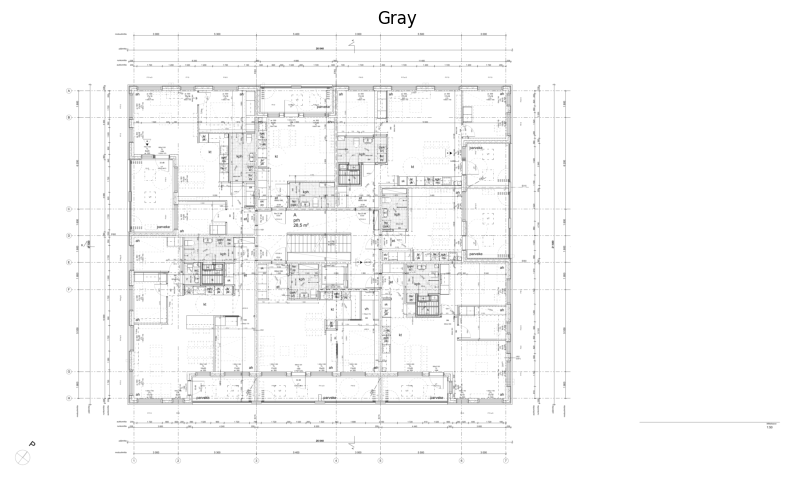

In [17]:
image = np.array(page)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

show_image("Gray", gray)

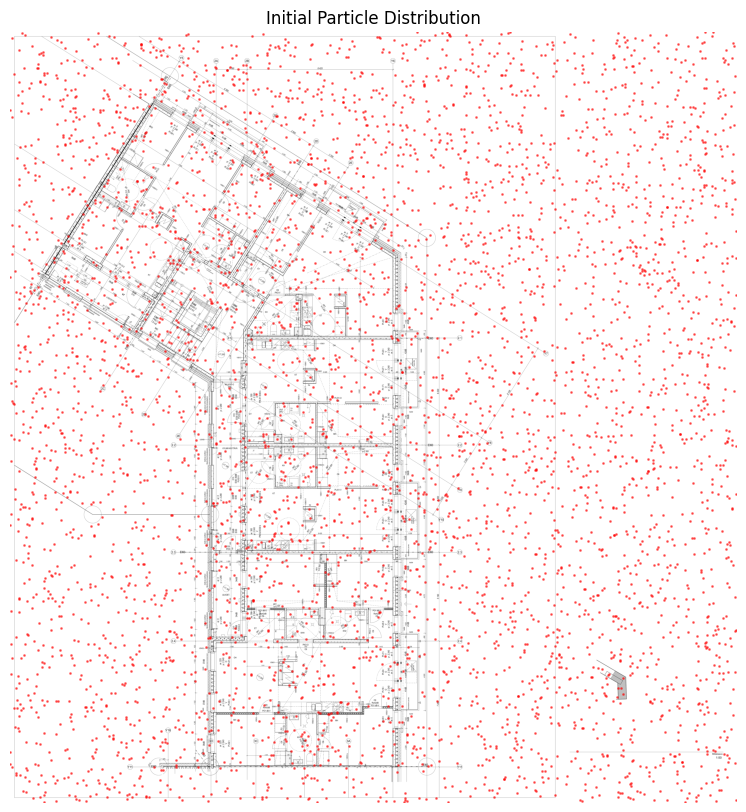

In [10]:
# Number of particles
num_particles = 5000

# Initialize particles randomly across the image
particles = np.empty((num_particles, 2))
particles[:, 0] = np.random.uniform(0, image.shape[1], num_particles)  # x-coordinates
particles[:, 1] = np.random.uniform(0, image.shape[0], num_particles)  # y-coordinates

# Initialize equal weights
weights = np.ones(num_particles) / num_particles

# Display initial particle positions
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.scatter(particles[:, 0], particles[:, 1], color='red', s=1, alpha=0.5)
plt.title('Initial Particle Distribution')
plt.axis('off')
plt.show()


In [13]:
def motion_model(particles, step_size=1):
    """
    Move particles based on a random walk motion model.
    """
    # Random movement in x and y directions
    dx = np.random.uniform(-step_size, step_size, size=num_particles)
    dy = np.random.uniform(-step_size, step_size, size=num_particles)
    particles[:, 0] += dx
    particles[:, 1] += dy

    # Keep particles within image bounds
    particles[:, 0] = np.clip(particles[:, 0], 0, image.shape[1] - 1)
    particles[:, 1] = np.clip(particles[:, 1], 0, image.shape[0] - 1)
    return particles


In [15]:
def observation_model(particles, image):
    """
    Update particle weights based on the likelihood of being on a wall.
    """
    # Get pixel values at particle locations
    x_indices = particles[:, 0].astype(np.int32)
    y_indices = particles[:, 1].astype(np.int32)
    pixel_values = image[y_indices, x_indices]

    # Assuming walls are darker than the background
    # Invert pixel values for weight calculation
    weights = 255 - pixel_values
    weights = weights.astype(np.float64)

    # Normalize weights
    weights += 1e-300  # Avoid division by zero
    weights /= np.sum(weights)
    return weights


In [16]:
num_iterations = 50  # Adjust based on convergence needs

for iteration in range(num_iterations):
    # Predict: Move particles
    particles = motion_model(particles)

    # Update: Calculate weights based on observation
    weights = observation_model(particles, image)

    # Resample: Systematic resampling
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.0  # Ensure sum is exactly one
    indexes = np.searchsorted(cumulative_sum, np.random.rand(num_particles))

    # Resample particles and weights
    particles = particles[indexes]
    weights = weights[indexes]
    weights /= np.sum(weights)

    # Optional: Add noise to particles to maintain diversity
    particles += np.random.normal(0, 0.5, particles.shape)

    # Keep particles within image bounds after adding noise
    particles[:, 0] = np.clip(particles[:, 0], 0, image.shape[1] - 1)
    particles[:, 1] = np.clip(particles[:, 1], 0, image.shape[0] - 1)

    # Debug: Print iteration info
    if (iteration + 1) % 10 == 0:
        print(f"Iteration {iteration + 1}/{num_iterations}")
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

class Particle:
    def __init__(self, x, y, theta, length, distance, weight=1.0):
        self.x = x
        self.y = y
        self.theta = theta  # in radians
        self.length = length
        self.distance = distance  # Distance between the parallel lines
        self.weight = weight

def initialize_particles(num_particles, image_shape):
    particles = []
    height, width = image_shape
    for _ in range(num_particles):
        x = random.uniform(0, width)
        y = random.uniform(0, height)
        theta = random.uniform(0, 2*np.pi)
        length = random.uniform(20, 100)  # Length between 20 and 100 pixels
        distance = random.uniform(5, 50)  # Distance between 5 and 50 pixels
        particles.append(Particle(x, y, theta, length, distance))
    return particles

def compute_likelihood(particle, edge_image):
    # Distance between the double lines (half of the wall thickness)
    d = particle.distance / 2

    # Generate points along the wall segment
    num_points = int(particle.length)
    xs = np.linspace(-particle.length/2, particle.length/2, num_points)
    ys = np.zeros(num_points)

    # Rotate points according to theta
    cos_theta = np.cos(particle.theta)
    sin_theta = np.sin(particle.theta)
    x_rot = xs * cos_theta - ys * sin_theta + particle.x
    y_rot = xs * sin_theta + ys * cos_theta + particle.y

    # Sample points for the two parallel lines
    dx = -np.sin(particle.theta) * d
    dy = np.cos(particle.theta) * d
    x_line1 = x_rot + dx
    y_line1 = y_rot + dy

    dx = -np.sin(particle.theta) * (-d)
    dy = np.cos(particle.theta) * (-d)
    x_line2 = x_rot + dx
    y_line2 = y_rot + dy

    # Ensure indices are within image bounds
    height, width = edge_image.shape
    x_line1 = np.clip(x_line1, 0, width-1).astype(np.int32)
    y_line1 = np.clip(y_line1, 0, height-1).astype(np.int32)
    x_line2 = np.clip(x_line2, 0, width-1).astype(np.int32)
    y_line2 = np.clip(y_line2, 0, height-1).astype(np.int32)

    # Get edge values at these points
    edge_values1 = edge_image[y_line1, x_line1]
    edge_values2 = edge_image[y_line2, x_line2]

    # Compute likelihood based on presence of edges at both lines
    # and penalize for edges between the lines (to reduce false positives)
    mask = np.zeros_like(edge_image, dtype=np.uint8)
    cv2.line(mask, (int(x_line1[0]), int(y_line1[0])), (int(x_line1[-1]), int(y_line1[-1])), 1, 1)
    cv2.line(mask, (int(x_line2[0]), int(y_line2[0])), (int(x_line2[-1]), int(y_line2[-1])), 1, 1)
    edge_between_lines = cv2.bitwise_and(edge_image, mask)
    penalty = np.sum(edge_between_lines)

    likelihood = np.sum(edge_values1) + np.sum(edge_values2) - penalty
    return likelihood

def normalize_weights(particles):
    total_weight = sum(p.weight for p in particles)
    if total_weight == 0:
        for p in particles:
            p.weight = 1.0 / len(particles)
    else:
        for p in particles:
            p.weight /= total_weight

def resample_particles(particles):
    weights = [p.weight for p in particles]
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.0  # Ensure the last value is 1
    indexes = np.searchsorted(cumulative_sum, np.random.rand(len(particles)))

    new_particles = []
    for idx in indexes:
        p = particles[idx]
        new_particle = Particle(p.x, p.y, p.theta, p.length, p.distance)
        new_particles.append(new_particle)
    return new_particles

def particle_filter(edge_image, num_particles=1000, num_iterations=5):
    particles = initialize_particles(num_particles, edge_image.shape)
    for iteration in range(num_iterations):
        # Compute weights
        for p in particles:
            likelihood = compute_likelihood(p, edge_image)
            p.weight = likelihood + 1e-10  # Avoid zero weight

        # Normalize weights
        normalize_weights(particles)

        # Resample particles
        particles = resample_particles(particles)

        # Add some noise to particles
        for p in particles:
            p.x += np.random.normal(0, 2)
            p.y += np.random.normal(0, 2)
            p.theta += np.random.normal(0, 0.05)
            p.length = np.clip(p.length + np.random.normal(0, 2), 20, 100)
            p.distance = np.clip(p.distance + np.random.normal(0, 2), 5, 50)

    return particles

def main():
    # Load image
    image = cv2.imread('image.png', cv2.IMREAD_GRAYSCALE)
    # Apply edge detection
    edge_image = cv2.Canny(image, 50, 150)
    # Run particle filter
    particles = particle_filter(edge_image)
    # Plot results
    plt.imshow(image, cmap='gray')
    for p in particles:
        # Draw the wall segments
        x0 = p.x - (p.length/2) * np.cos(p.theta)
        y0 = p.y - (p.length/2) * np.sin(p.theta)
        x1 = p.x + (p.length/2) * np.cos(p.theta)
        y1 = p.y + (p.length/2) * np.sin(p.theta)

        # Draw the two parallel lines
        d = p.distance / 2
        dx = -np.sin(p.theta) * d
        dy = np.cos(p.theta) * d

        x0_line1 = x0 + dx
        y0_line1 = y0 + dy
        x1_line1 = x1 + dx
        y1_line1 = y1 + dy

        x0_line2 = x0 - dx
        y0_line2 = y0 - dy
        x1_line2 = x1 - dx
        y1_line2 = y1 - dy

        plt.plot([x0_line1, x1_line1], [y0_line1, y1_line1], 'r-', linewidth=2, alpha=0.1)
        plt.plot([x0_line2, x1_line2], [y0_line2, y1_line2], 'r-', linewidth=2, alpha=0.1)

    plt.title('Detected Walls Using Particle Filter with Variable Distances')
    plt.show()

if __name__ == "__main__":
    main()


TypeError: list indices must be integers or slices, not tuple

In [14]:
# Create a heatmap of particle densities
heatmap, xedges, yedges = np.histogram2d(
    particles[:, 1], particles[:, 0],
    bins=(image.shape[0], image.shape[1]),
    weights=weights
)

# Normalize heatmap for visualization
heatmap /= np.max(heatmap)


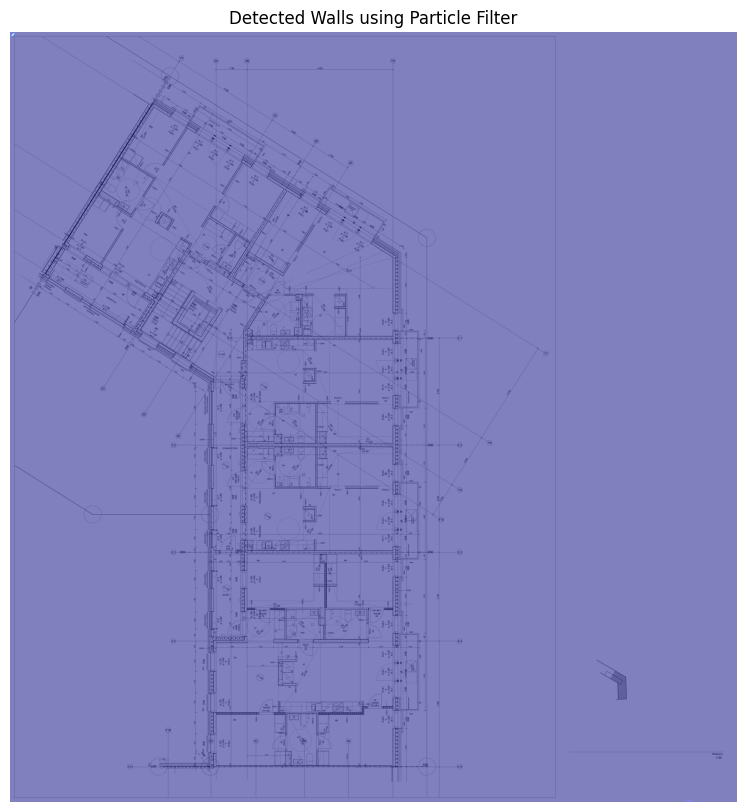

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
plt.title('Detected Walls using Particle Filter')
plt.axis('off')
plt.show()


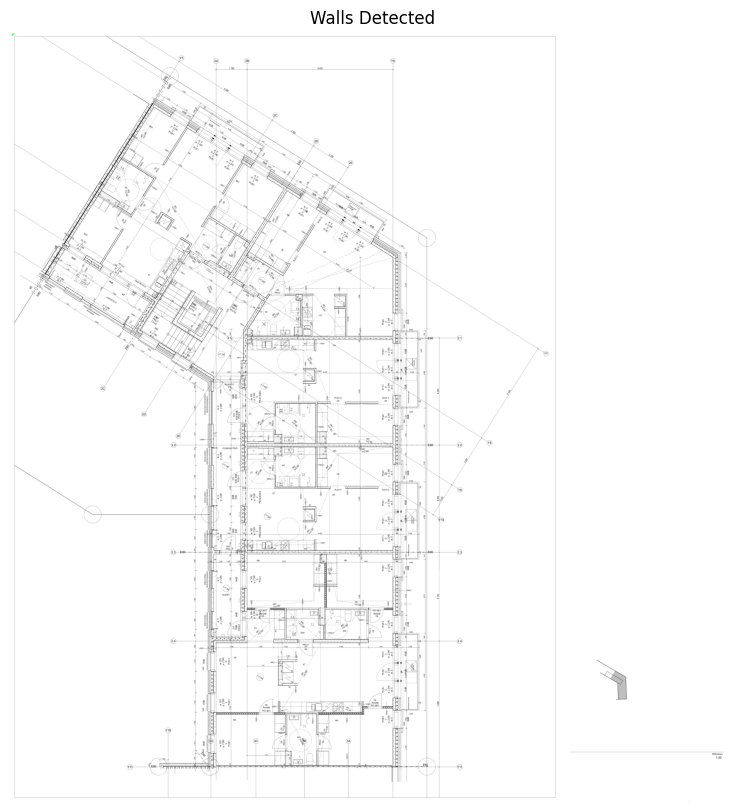

In [16]:
# Threshold the heatmap to create a binary image
threshold = 0.5  # Adjust based on results
binary_heatmap = (heatmap > threshold).astype(np.uint8) * 255

# Find contours of the walls
contours, _ = cv2.findContours(binary_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
image_with_walls = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(image_with_walls, contours, -1, (0, 255, 0), 2)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_walls, cv2.COLOR_BGR2RGB))
plt.title('Walls Detected')
plt.axis('off')
plt.show()


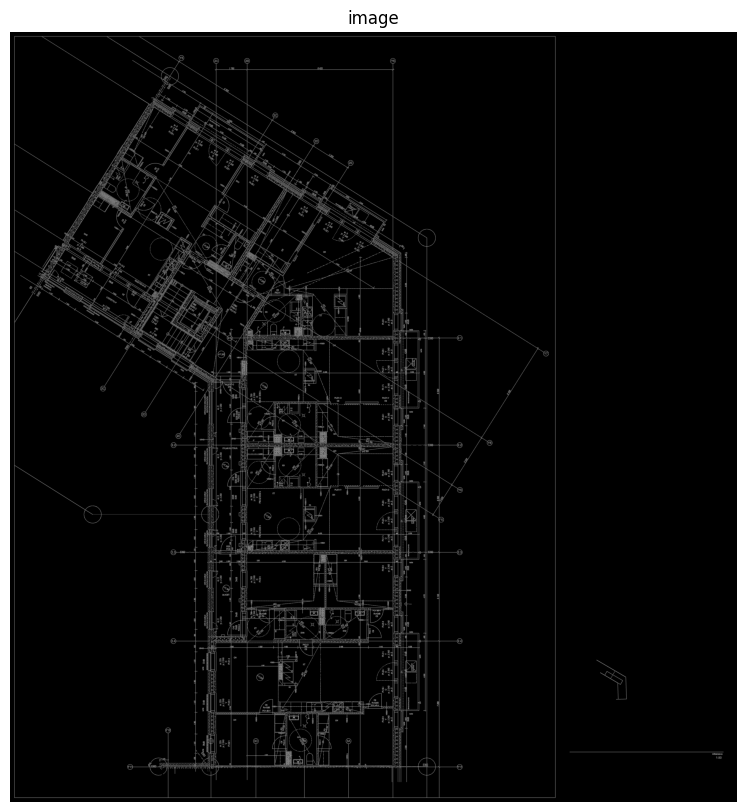

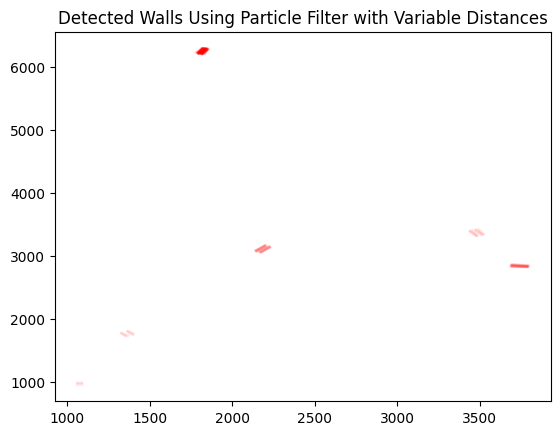

In [24]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

class Particle:
    def __init__(self, x, y, theta, length, distance, weight=1.0):
        self.x = x
        self.y = y
        self.theta = theta  # in radians
        self.length = length
        self.distance = distance  # Distance between the parallel lines
        self.weight = weight

def initialize_particles(num_particles, image_shape):
    particles = []
    height, width = image_shape
    for _ in range(num_particles):
        x = random.uniform(0, width)
        y = random.uniform(0, height)
        theta = random.uniform(0, 2*np.pi)
        length = random.uniform(20, 100)  # Length between 20 and 100 pixels
        distance = random.uniform(5, 50)  # Distance between 5 and 50 pixels
        particles.append(Particle(x, y, theta, length, distance))
    return particles

def compute_likelihood(particle, edge_image):
    # Distance between the double lines (half of the wall thickness)
    d = particle.distance / 2

    # Generate points along the wall segment
    num_points = int(particle.length)
    xs = np.linspace(-particle.length/2, particle.length/2, num_points)
    ys = np.zeros(num_points)

    # Rotate points according to theta
    cos_theta = np.cos(particle.theta)
    sin_theta = np.sin(particle.theta)
    x_rot = xs * cos_theta - ys * sin_theta + particle.x
    y_rot = xs * sin_theta + ys * cos_theta + particle.y

    # Sample points for the two parallel lines
    dx = -np.sin(particle.theta) * d
    dy = np.cos(particle.theta) * d
    x_line1 = x_rot + dx
    y_line1 = y_rot + dy

    dx = -np.sin(particle.theta) * (-d)
    dy = np.cos(particle.theta) * (-d)
    x_line2 = x_rot + dx
    y_line2 = y_rot + dy

    # Ensure indices are within image bounds
    height, width = edge_image.shape
    x_line1 = np.clip(x_line1, 0, width-1).astype(np.int32)
    y_line1 = np.clip(y_line1, 0, height-1).astype(np.int32)
    x_line2 = np.clip(x_line2, 0, width-1).astype(np.int32)
    y_line2 = np.clip(y_line2, 0, height-1).astype(np.int32)

    # Get edge values at these points
    edge_values1 = edge_image[y_line1, x_line1]
    edge_values2 = edge_image[y_line2, x_line2]

    # Compute likelihood based on presence of edges at both lines
    # and penalize for edges between the lines (to reduce false positives)
    mask = np.zeros_like(edge_image, dtype=np.uint8)
    cv2.line(mask, (int(x_line1[0]), int(y_line1[0])), (int(x_line1[-1]), int(y_line1[-1])), 1, 1)
    cv2.line(mask, (int(x_line2[0]), int(y_line2[0])), (int(x_line2[-1]), int(y_line2[-1])), 1, 1)
    edge_between_lines = cv2.bitwise_and(edge_image, mask)
    penalty = np.sum(edge_between_lines)

    likelihood = np.sum(edge_values1) + np.sum(edge_values2) - penalty
    return likelihood

def normalize_weights(particles):
    total_weight = sum(p.weight for p in particles)
    if total_weight == 0:
        for p in particles:
            p.weight = 1.0 / len(particles)
    else:
        for p in particles:
            p.weight /= total_weight

def resample_particles(particles):
    weights = [p.weight for p in particles]
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.0  # Ensure the last value is 1
    indexes = np.searchsorted(cumulative_sum, np.random.rand(len(particles)))

    new_particles = []
    for idx in indexes:
        p = particles[idx]
        new_particle = Particle(p.x, p.y, p.theta, p.length, p.distance)
        new_particles.append(new_particle)
    return new_particles

def particle_filter(edge_image, num_particles=50, num_iterations=5):
    particles = initialize_particles(num_particles, edge_image.shape)
    for iteration in range(num_iterations):
        # Compute weights
        for p in particles:
            likelihood = compute_likelihood(p, edge_image)
            p.weight = likelihood + 1e-10  # Avoid zero weight

        # Normalize weights
        normalize_weights(particles)

        # Resample particles
        particles = resample_particles(particles)

        # Add some noise to particles
        for p in particles:
            p.x += np.random.normal(0, 2)
            p.y += np.random.normal(0, 2)
            p.theta += np.random.normal(0, 0.05)
            p.length = np.clip(p.length + np.random.normal(0, 2), 20, 100)
            p.distance = np.clip(p.distance + np.random.normal(0, 2), 5, 50)

    return particles

def main():
    # Load image
    edge_image = cv2.Canny(image, 50, 150)
    # Run particle filter
    particles = particle_filter(edge_image)
    # Plot results
    show_image("image", edge_image)
    for p in particles:
        # Draw the wall segments
        x0 = p.x - (p.length/2) * np.cos(p.theta)
        y0 = p.y - (p.length/2) * np.sin(p.theta)
        x1 = p.x + (p.length/2) * np.cos(p.theta)
        y1 = p.y + (p.length/2) * np.sin(p.theta)

        # Draw the two parallel lines
        d = p.distance / 2
        dx = -np.sin(p.theta) * d
        dy = np.cos(p.theta) * d

        x0_line1 = x0 + dx
        y0_line1 = y0 + dy
        x1_line1 = x1 + dx
        y1_line1 = y1 + dy

        x0_line2 = x0 - dx
        y0_line2 = y0 - dy
        x1_line2 = x1 - dx
        y1_line2 = y1 - dy

        plt.plot([x0_line1, x1_line1], [y0_line1, y1_line1], 'r-', linewidth=2, alpha=0.1)
        plt.plot([x0_line2, x1_line2], [y0_line2, y1_line2], 'r-', linewidth=2, alpha=0.1)

    plt.title('Detected Walls Using Particle Filter with Variable Distances')
    plt.show()
main()


Iteration 1/5 completed.
Iteration 2/5 completed.
Iteration 3/5 completed.
Iteration 4/5 completed.
Iteration 5/5 completed.


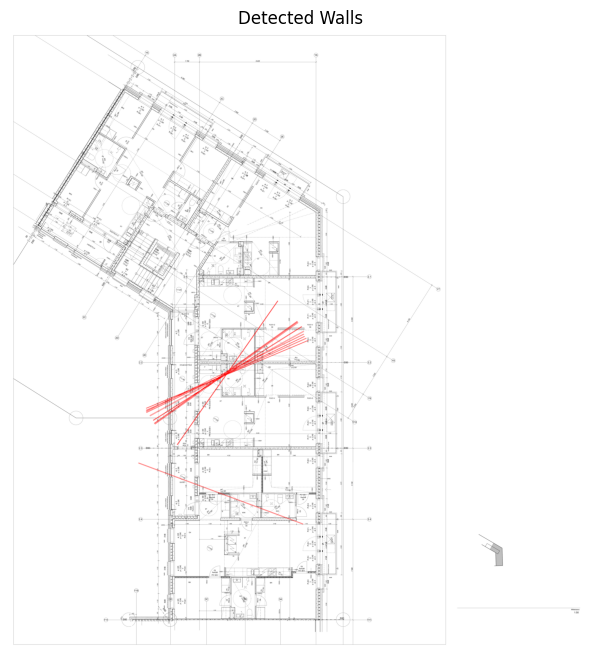

In [26]:
# Import necessary libraries
import cv2
import numpy as np
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline

def line_segment_distance(x1_p, y1_p, x2_p, y2_p, x1_q, y1_q, x2_q, y2_q):
    """Compute the minimum distance between two line segments."""
    def point_segment_distance_sq(px, py, x1, y1, x2, y2):
        # Compute squared distance between point and segment
        line_mag_sq = (x2 - x1)**2 + (y2 - y1)**2
        if line_mag_sq == 0:
            return (px - x1)**2 + (py - y1)**2
        u = ((px - x1)*(x2 - x1) + (py - y1)*(y2 - y1)) / line_mag_sq
        u = max(0, min(1, u))
        ix = x1 + u*(x2 - x1)
        iy = y1 + u*(y2 - y1)
        return (px - ix)**2 + (py - iy)**2

    distances = [
        point_segment_distance_sq(x1_p, y1_p, x1_q, y1_q, x2_q, y2_q),
        point_segment_distance_sq(x2_p, y2_p, x1_q, y1_q, x2_q, y2_q),
        point_segment_distance_sq(x1_q, y1_q, x1_p, y1_p, x2_p, y2_p),
        point_segment_distance_sq(x2_q, y2_q, x1_p, y1_p, x2_p, y2_p),
    ]

    min_distance_sq = min(distances)
    return math.sqrt(min_distance_sq)

def compute_weight(x, y, theta, width, lines):
    """Compute the weight of a particle based on how well it matches detected lines."""
    length = 1000  # Length of the wall hypothesis
    dx = length * math.cos(theta)
    dy = length * math.sin(theta)

    # Calculate offsets for wall thickness
    offset_x = (width / 2) * math.sin(theta)
    offset_y = -(width / 2) * math.cos(theta)

    # Endpoints for the two parallel lines representing the wall
    x1_start = x + offset_x - dx
    y1_start = y + offset_y - dy
    x1_end = x + offset_x + dx
    y1_end = y + offset_y + dy

    x2_start = x - offset_x - dx
    y2_start = y - offset_y - dy
    x2_end = x - offset_x + dx
    y2_end = y - offset_y + dy

    total_overlap = 0
    if lines is not None:
        for line in lines:
            x1_line, y1_line, x2_line, y2_line = line[0]
            # Compute distances to the wall hypothesis lines
            dist1 = line_segment_distance(x1_line, y1_line, x2_line, y2_line,
                                          x1_start, y1_start, x1_end, y1_end)
            dist2 = line_segment_distance(x1_line, y1_line, x2_line, y2_line,
                                          x2_start, y2_start, x2_end, y2_end)

            # Increase overlap if the distance is small
            if dist1 < 5 or dist2 < 5:
                total_overlap += 1 / (dist1 + dist2 + 1e-5)  # Avoid division by zero

    return total_overlap

def resample_particles(particles, weights):
    """Resample particles based on their weights using the systematic resampling method."""
    new_particles = []
    N = len(particles)
    positions = (np.arange(N) + random.random()) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    for idx in indexes:
        new_particles.append(particles[idx])
    return new_particles

# Load the architectural drawing
# Replace 'architectural_drawing.png' with your image path
img = image
if img is None:
    raise FileNotFoundError("Image file not found. Please check the path and filename.")

# Edge detection
edges = cv2.Canny(img, 50, 150, apertureSize=3)

# Detect lines using Hough Transform
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80,
                        minLineLength=30, maxLineGap=10)

num_particles = 50
particles = []

# Initialize particles randomly across the image
for _ in range(num_particles):
    x = random.uniform(0, img.shape[1])
    y = random.uniform(0, img.shape[0])
    theta = random.uniform(0, np.pi)
    width = random.uniform(5, 50)  # Wall thickness between 5 and 50 pixels
    particles.append([x, y, theta, width])

num_iterations = 5

for iteration in range(num_iterations):
    # Prediction step: Slightly perturb particle states
    for i in range(num_particles):
        x, y, theta, width = particles[i]
        x += random.gauss(0, 5)
        y += random.gauss(0, 5)
        theta += random.gauss(0, 0.1)
        width += random.gauss(0, 2)
        # Ensure particles remain within image bounds
        x = min(max(x, 0), img.shape[1] - 1)
        y = min(max(y, 0), img.shape[0] - 1)
        theta = theta % np.pi
        width = min(max(width, 5), 50)
        particles[i] = [x, y, theta, width]
    
    # Update step: Calculate weights based on overlap with detected lines
    weights = []
    for i in range(num_particles):
        x, y, theta, width = particles[i]
        weight = compute_weight(x, y, theta, width, lines)
        weights.append(weight)
    
    # Normalize weights
    sum_weights = sum(weights)
    if sum_weights == 0:
        weights = [1.0 / num_particles] * num_particles
    else:
        weights = [w / sum_weights for w in weights]
    
    # Resample particles
    particles = resample_particles(particles, weights)
    
    print(f"Iteration {iteration + 1}/{num_iterations} completed.")

# Select top particles as the best wall hypotheses
top_N = 10
particles_with_weights = list(zip(particles, weights))
particles_with_weights.sort(key=lambda x: x[1], reverse=True)
top_particles = [pw[0] for pw in particles_with_weights[:top_N]]

# Draw detected walls on the image
output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

for particle in top_particles:
    x, y, theta, width = particle
    length = 1000  # Length for drawing the wall lines
    dx = length * math.cos(theta)
    dy = length * math.sin(theta)

    offset_x = (width / 2) * math.sin(theta)
    offset_y = -(width / 2) * math.cos(theta)

    # Endpoints for the first line
    x1_start = int(x + offset_x - dx)
    y1_start = int(y + offset_y - dy)
    x1_end = int(x + offset_x + dx)
    y1_end = int(y + offset_y + dy)

    # Endpoints for the second line
    x2_start = int(x - offset_x - dx)
    y2_start = int(y - offset_y - dy)
    x2_end = int(x - offset_x + dx)
    y2_end = int(y - offset_y + dy)

    # Draw the wall lines
    cv2.line(output_img, (x1_start, y1_start), (x1_end, y1_end), (0, 0, 255), 2)
    cv2.line(output_img, (x2_start, y2_start), (x2_end, y2_end), (0, 0, 255), 2)

# Convert BGR to RGB for displaying with matplotlib
output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

# Display the result inline using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(output_img_rgb)
plt.title('Detected Walls')
plt.axis('off')
plt.show()


In [11]:
# Import necessary libraries
import cv2
import numpy as np
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline

def compute_weight(x, y, theta, width, edges):
    """Compute the weight of a particle based on edge intensities along the wall hypothesis."""
    length = 1000  # Length of the wall hypothesis
    dx = length * math.cos(theta)
    dy = length * math.sin(theta)

    # Calculate offsets for wall thickness
    offset_x = (width / 2) * math.sin(theta)
    offset_y = -(width / 2) * math.cos(theta)

    # Endpoints for the two parallel lines representing the wall
    x1_start = x + offset_x - dx
    y1_start = y + offset_y - dy
    x1_end = x + offset_x + dx
    y1_end = y + offset_y + dy

    x2_start = x - offset_x - dx
    y2_start = y - offset_y - dy
    x2_end = x - offset_x + dx
    y2_end = y - offset_x + dy

    # Sample points along the wall lines
    num_samples = int(2 * length / 10)  # Sample every 10 pixels
    line1_x = np.linspace(x1_start, x1_end, num_samples)
    line1_y = np.linspace(y1_start, y1_end, num_samples)
    line2_x = np.linspace(x2_start, x2_end, num_samples)
    line2_y = np.linspace(y2_start, y2_end, num_samples)

    # Initialize weight
    total_intensity = 0

    # Collect edge intensities along the two lines
    for lx, ly in zip(np.concatenate([line1_x, line2_x]), np.concatenate([line1_y, line2_y])):
        lx_int = int(round(lx))
        ly_int = int(round(ly))
        if 0 <= lx_int < edges.shape[1] and 0 <= ly_int < edges.shape[0]:
            intensity = edges[ly_int, lx_int]
            total_intensity += intensity / 255.0  # Normalize intensity to [0,1]

    return total_intensity

def resample_particles(particles, weights):
    """Resample particles based on their weights using the systematic resampling method."""
    new_particles = []
    N = len(particles)
    positions = (np.arange(N) + random.random()) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    for idx in indexes:
        new_particles.append(particles[idx])
    return new_particles

# Load the architectural drawing
# Replace 'architectural_drawing.png' with your image path
img = image
if img is None:
    raise FileNotFoundError("Image file not found. Please check the path and filename.")

# Edge detection
edges = cv2.Canny(img, 50, 150, apertureSize=3)

num_particles = 1000
particles = []

# Initialize particles randomly across the image
for _ in range(num_particles):
    x = random.uniform(0, img.shape[1])
    y = random.uniform(0, img.shape[0])
    theta = random.uniform(0, np.pi)
    width = random.uniform(5, 50)  # Wall thickness between 5 and 50 pixels
    particles.append([x, y, theta, width])

num_iterations = 5

for iteration in range(num_iterations):
    # Prediction step: Slightly perturb particle states
    for i in range(num_particles):
        x, y, theta, width = particles[i]
        x += random.gauss(0, 5)
        y += random.gauss(0, 5)
        theta += random.gauss(0, 0.1)
        width += random.gauss(0, 2)
        # Ensure particles remain within image bounds
        x = min(max(x, 0), img.shape[1] - 1)
        y = min(max(y, 0), img.shape[0] - 1)
        theta = theta % np.pi
        width = min(max(width, 5), 50)
        particles[i] = [x, y, theta, width]
    
    # Update step: Calculate weights based on edge intensities along wall hypotheses
    weights = []
    for i in range(num_particles):
        x, y, theta, width = particles[i]
        weight = compute_weight(x, y, theta, width, edges)
        weights.append(weight)
    
    # Normalize weights
    sum_weights = sum(weights)
    if sum_weights == 0:
        weights = [1.0 / num_particles] * num_particles
    else:
        weights = [w / sum_weights for w in weights]
    
    # Resample particles
    particles = resample_particles(particles, weights)
    
    print(f"Iteration {iteration + 1}/{num_iterations} completed.")

# Select top particles as the best wall hypotheses
top_N = 10
particles_with_weights = list(zip(particles, weights))
particles_with_weights.sort(key=lambda x: x[1], reverse=True)
top_particles = [pw[0] for pw in particles_with_weights[:top_N]]

# Draw detected walls on the image
output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

for particle in top_particles:
    x, y, theta, width = particle
    length = 1000  # Length for drawing the wall lines
    dx = length * math.cos(theta)
    dy = length * math.sin(theta)

    offset_x = (width / 2) * math.sin(theta)
    offset_y = -(width / 2) * math.cos(theta)

    # Endpoints for the first line
    x1_start = int(x + offset_x - dx)
    y1_start = int(y + offset_y - dy)
    x1_end = int(x + offset_x + dx)
    y1_end = int(y + offset_y + dy)

    # Endpoints for the second line
    x2_start = int(x - offset_x - dx)
    y2_start = int(y - offset_y - dy)
    x2_end = int(x - offset_x + dx)
    y2_end = int(y - offset_y + dy)

    # Draw the wall lines
    cv2.line(output_img, (x1_start, y1_start), (x1_end, y1_end), (0, 0, 255), 2)
    cv2.line(output_img, (x2_start, y2_start), (x2_end, y2_end), (0, 0, 255), 2)

# Convert BGR to RGB for displaying with matplotlib
output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

# Display the result inline using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(output_img_rgb)
plt.title('Detected Walls')
plt.axis('off')
plt.show()


Iteration 1/5 completed.
Iteration 2/5 completed.
Iteration 3/5 completed.
Iteration 4/5 completed.
Iteration 5/5 completed.


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<1>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 3


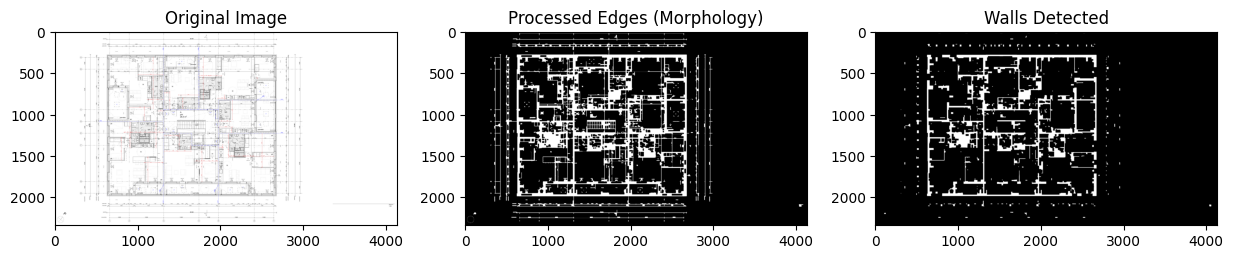

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.GaussianBlur(gray, (11, 11), 0)
# Apply edge detection
edges = cv2.Canny(img, threshold1=50, threshold2=150, apertureSize=3)

# Apply a morphological closing operation to emphasize thick lines (walls)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

walls = cv2.erode(closed, np.ones((11, 11)))
walls = cv2.dilate(walls, np.ones((5, 5)))
# Display the original, edges, and walls detected
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(closed, cmap='gray')
plt.title("Processed Edges (Morphology)")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(walls, cv2.COLOR_BGR2RGB))
plt.title("Walls Detected")

plt.show()


In [41]:
filtered_lines

array([[1313, 1989, 1313,  649],
       [ 987,  302, 2678,  302],
       [ 812, 1979, 2381, 1979],
       [ 640, 1989,  640,  594],
       [1969, 1233, 2678, 1220],
       [2212,  823, 2678,  839],
       [ 951, 1274, 1153, 1264],
       [2664, 1320, 2678,  555],
       [1982, 1624, 1982,  812],
       [1001,  530, 1369,  543],
       [ 641,  287,  645,  514],
       [1482,  801, 1874,  801],
       [1071, 1825, 1306, 1829],
       [1743,  955, 1743,  461],
       [1646, 1380, 1981, 1368],
       [1478, 1088, 1818, 1088],
       [1478, 1084, 1817, 1078],
       [ 986, 1321, 1260, 1297],
       [ 951, 1251, 1153, 1279],
       [2415,  682, 2425, 1232],
       [ 654, 1715,  659, 1410],
       [2244, 1214, 2387, 1204],
       [1322,  948, 1987,  948],
       [1475, 1830, 1606, 1833],
       [2467,  822, 2665,  835],
       [1437,  434, 1737,  449],
       [2414,  916, 2414,  682],
       [1322, 1249, 1567, 1237],
       [1786,  564, 2014,  564],
       [1044, 1098, 1307, 1089],
       [17

In [75]:
min(1,2, 3)

1

In [78]:
lines = cv2.HoughLinesP(walls, rho=1, theta=np.pi/180, threshold=200, minLineLength=50, maxLineGap=10)

lines = lines.reshape(lines.shape[0], lines.shape[2])
# Create an empty image to draw wall lines
wall_lines = np.zeros_like(walls)

filtered_lines = filter_similar_lines(lines, delta_theta=2.0, delta_rho=3.0, min_parallel_lines=10)
# Draw the detected lines onto the empty image
lines_json = []
min_x = None
min_y = None
max_x = None
max_y = None
if filtered_lines is not None:
    for line in filtered_lines:
        x1, y1, x2, y2 = line
        cv2.line(wall_lines, (x1, y1), (x2, y2), (255, 255, 255), 2)
        if min_x is None:
            min_x = min(float(x1), float(x2))
        else:
            min_x = min(float(x1), float(x2), min_x)
        if min_y is None:
            min_y = min(float(y1), float(y2))
        else:
            min_y = min(float(y1), float(y2), min_y)

        if max_x is None:
            max_x = max(float(x1), float(x2))
        else:
            max_x = max(float(x1), float(x2), max_x)
        if max_y is None:
            max_y = max(float(y1), float(y2))
        else:
            max_y = max(float(y1), float(y2), max_y)
        
        lines_json.append([float(x1), float(y1), float(x2), float(y2)])

for l in lines_json:
    l[0] -= min_x
    l[0] /= max_x - min_x
    l[1] -= min_y
    l[1] /= max_y - min_y
    l[2] -= min_x
    l[2] /= max_x - min_x
    l[3] -= min_y
    l[3] /= max_y - min_y
    
import json
print(json.dumps(lines_json, indent=True))

#show_image("Hello", wall_lines)

[
 [
  0.16863323500491642,
  0.00881316098707403,
  1.0,
  0.00881316098707403
 ],
 [
  0.32890855457227136,
  1.0,
  0.32890855457227136,
  0.21269095182138661
 ],
 [
  0.08259587020648967,
  1.0,
  0.8539823008849557,
  1.0
 ],
 [
  0.0,
  1.0,
  0.0,
  0.18037602820211515
 ],
 [
  0.9911504424778761,
  0.6069330199764983,
  0.9980334316617503,
  0.15746180963572268
 ],
 [
  0.7699115044247787,
  0.31609870740305523,
  1.0,
  0.3207990599294947
 ],
 [
  0.41002949852507375,
  0.4688601645123384,
  0.5771878072763028,
  0.4688601645123384
 ],
 [
  0.5398230088495575,
  0.39247943595769685,
  0.5398230088495575,
  0.10223266745005875
 ],
 [
  0.9980334316617503,
  0.8407755581668626,
  1.0,
  0.9976498237367802
 ],
 [
  0.20993117010816126,
  0.9059929494712103,
  0.3416912487708948,
  0.9059929494712103
 ],
 [
  0.30383480825958703,
  0.3871915393654524,
  0.6529006882989183,
  0.3871915393654524
 ],
 [
  0.17551622418879056,
  0.14218566392479437,
  0.35644051130776794,
  0.14982373

In [43]:
import numpy as np
from sklearn.cluster import DBSCAN

def filter_similar_lines(lines, delta_theta=0.05, delta_rho=5.0, min_parallel_lines=2):
    """
    Filters out lines that are close to parallel and close to each other,
    only including lines where there are at least 'min_parallel_lines' similar lines.

    Parameters:
    - lines: NumPy array of shape (N, 4), where each row is (x1, y1, x2, y2).
    - delta_theta: Threshold for angular difference in radians.
    - delta_rho: Threshold for distance difference.
    - min_parallel_lines: Minimum number of similar lines required to include a line.

    Returns:
    - filtered_lines: NumPy array of filtered lines.
    """
    x1 = lines[:, 0]
    y1 = lines[:, 1]
    x2 = lines[:, 2]
    y2 = lines[:, 3]
    dx = x2 - x1
    dy = y2 - y1

    # Compute normal vector (-dy, dx)
    nx = -dy
    ny = dx

    # Compute θ = atan2(ny, nx)
    theta = np.arctan2(ny, nx)
    theta = np.mod(theta, np.pi)  # Ensure θ is between 0 and π

    # Compute ρ = x1 * cos θ + y1 * sin θ
    rho = x1 * np.cos(theta) + y1 * np.sin(theta)

    # Scale θ and ρ for clustering
    theta_scaled = theta / delta_theta
    rho_scaled = rho / delta_rho
    features = np.column_stack((theta_scaled, rho_scaled))

    # Cluster lines using DBSCAN
    eps = np.sqrt(2)
    db = DBSCAN(eps=eps, min_samples=1).fit(features)
    labels = db.labels_

    # Select clusters with at least 'min_parallel_lines' lines
    unique_labels = np.unique(labels)
    filtered_lines = []
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        if len(indices) >= min_parallel_lines:
            cluster_lines = lines[indices]
            # Optionally, pick the longest line
            lengths = np.sqrt((cluster_lines[:, 2] - cluster_lines[:, 0])**2 +
                              (cluster_lines[:, 3] - cluster_lines[:, 1])**2)
            max_index = indices[np.argmax(lengths)]
            filtered_lines.append(lines[max_index])

    if filtered_lines:
        return np.array(filtered_lines)
    else:
        return np.empty((0, 4))  # Return an empty array if no lines meet the criteria


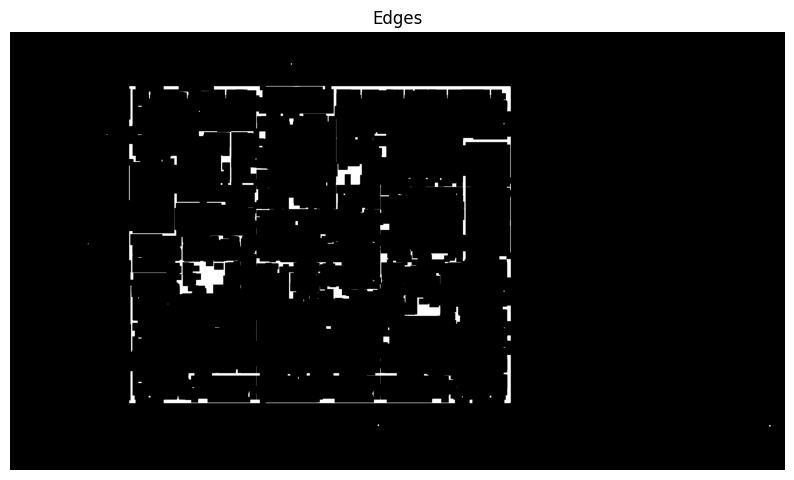

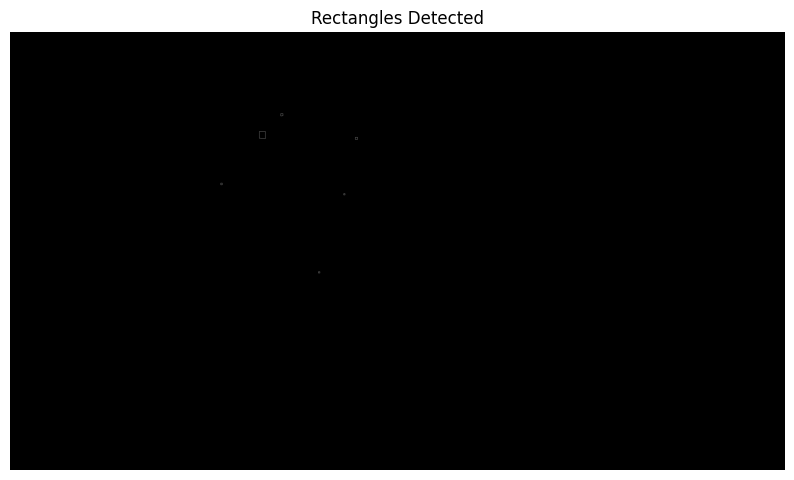

[array([[[1645, 1282]],
 
        [[1645, 1289]],
 
        [[1653, 1289]],
 
        [[1653, 1282]]], dtype=int32),
 array([[[1780,  866]],
 
        [[1780,  873]],
 
        [[1787,  873]],
 
        [[1787,  866]]], dtype=int32),
 array([[[1124,  810]],
 
        [[1124,  819]],
 
        [[1132,  819]],
 
        [[1132,  810]]], dtype=int32),
 array([[[1842,  566]],
 
        [[1842,  577]],
 
        [[1854,  577]],
 
        [[1854,  566]]], dtype=int32),
 array([[[1330,  535]],
 
        [[1330,  571]],
 
        [[1362,  573]],
 
        [[1362,  535]]], dtype=int32),
 array([[[1444,  440]],
 
        [[1444,  452]],
 
        [[1456,  451]],
 
        [[1456,  440]]], dtype=int32)]

In [8]:
import cv2
import numpy as np

def detect_rectangles():
    # Load the image
    if image is None:
        print("Could not open or find the image.")
        return
    
    # Convert the image to grayscale
    img = cv2.GaussianBlur(image, (11, 11), 0)
    # Apply edge detection
    edges = cv2.Canny(img, threshold1=50, threshold2=150, apertureSize=3)

    # Apply a morphological closing operation to emphasize thick lines (walls)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    walls = cv2.erode(closed, np.ones((21, 21)))
    
    show_image("Edges", walls)
    # Find contours in the edged image
    contours, _ = cv2.findContours(walls, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    rectangles = []

    new_image = np.zeros(edges.shape)
    # Loop through each contour
    for contour in contours:
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Check if the approximated contour has 4 vertices
        if len(approx) == 4:
            # Calculate aspect ratio to ensure it’s roughly a rectangle
            (x, y, w, h) = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h
            if 0.8 <= aspect_ratio <= 1.2:  # Assuming rectangles are not too skewed
                rectangles.append(approx)
                
                # Draw the rectangle on the original image for visualization
                cv2.drawContours(new_image, [approx], -1, (255, 255, 255), 1)
    
    # Show the result
    show_image("Rectangles Detected", new_image)
    
    return rectangles

# Example usage
detect_rectangles()


In [102]:
import cv2
import numpy as np

def extract_rooms():
    # Read the image and convert it to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to create a binary image
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a list to store the extracted room images
    rooms = []

    # Iterate over the contours and extract the rooms
    for contour in contours:
        # Get the bounding rectangle of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Filter out small contours (noise)
        if w > 50 and h > 50:
            # Extract the room image
            room = image[y:y+h, x:x+w]
            rooms.append(room)

    return rooms

# Provide the path to your floor plan image
image_path = "floor_plan.jpg"

# Extract the rooms
extracted_rooms = extract_rooms()

# Save the extracted room images
for i, room in enumerate(extracted_rooms):
    cv2.imwrite(f"room_{i}.jpg", room)

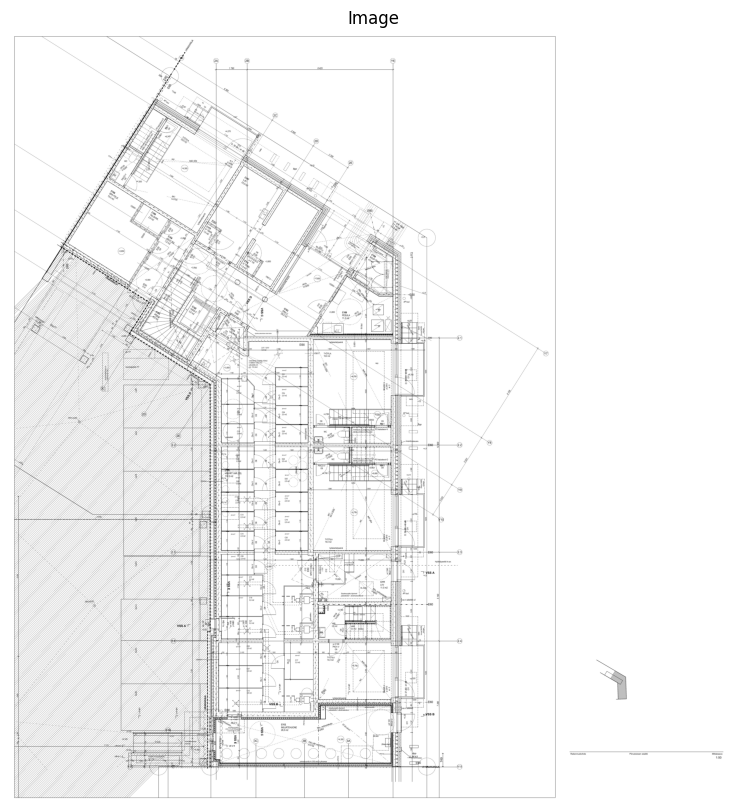

In [105]:
show_image("Image", image)

In [ ]:
cv2.Threshold